In [ ]:
import pickle as pk
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import os, sys, pathlib, h5py, time

from models import make_model

import pickle as pk

from astropy.nddata import block_reduce

from matplotlib import pyplot as plt

from astropy.io import fits

%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load and perform some cuts on data

In [47]:
data_dir = '/project/r/rbond/jorlo/datasets/act_freq_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']


In [48]:
stamps.shape

(4195, 41, 41, 3)

In [49]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [50]:
stamps.shape

(4195, 41, 41, 3)

In [51]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal']

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# A simple Dense Model

In [52]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 5043)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                322816    
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 327,041
Trainable params: 327,041
Non-trainable params: 0
_________________________________________________________________


In [54]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)




Epoch 1/50
6/6 [==============================] - 1s 42ms/step - loss: 2.1290 - val_loss: 1.2636
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0758 - val_loss: 1.0853
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 0.8692 - val_loss: 1.1297
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.7232 - val_loss: 0.9943
Epoch 5/50
6/6 [==============================] - 0s 23ms/step - loss: 0.6428 - val_loss: 0.9955
Epoch 6/50
6/6 [==============================] - 0s 23ms/step - loss: 0.6350 - val_loss: 1.0176
Epoch 7/50
6/6 [==============================] - 0s 23ms/step - loss: 0.5879 - val_loss: 1.0797
Epoch 8/50
6/6 [==============================] - 0s 23ms/step - loss: 0.5684 - val_loss: 0.9812
Epoch 9/50
6/6 [==============================] - 0s 24ms/step - loss: 0.5025 - val_loss: 1.0069
Epoch 10/50
6/6 [==============================] - 0s 22ms/step - loss: 0.4503 - val_loss: 1.0037
Epoch 11/50
6/6 [============

In [55]:
predictions = model.predict(train_dataset)
for i in range(len(train_labels)):
    print(train_labels[i]-predictions[i])
#It does shit

[-1.322206]
[-4.1848288]
[0.62935257]
[-1.5596745]
[-0.9097085]
[-2.0816574]
[-7.2058144]
[0.2578566]
[1.8290396]
[-5.819723]
[0.09744024]
[-2.5317466]
[-0.79503274]
[0.76748323]
[1.2818494]
[-0.5636425]
[-0.73969793]
[0.26605558]
[0.42869115]
[-0.4438734]
[-0.04729819]
[-0.05511546]
[5.629614]
[-0.17271757]
[-2.7422109]
[2.0656886]
[-0.04578567]
[0.01168871]
[3.7524602]
[0.6338148]
[-2.6980171]
[1.6342628]
[-1.0446422]
[-2.5664685]
[0.4532194]
[-0.01426482]
[2.643563]
[-0.21050858]
[-0.5266087]
[-0.42185497]
[2.1604018]
[-0.7545538]
[0.51746583]
[-0.36840558]
[0.2689941]
[-2.9526591]
[-0.9209652]
[-1.187269]
[3.5167344]
[-0.26876974]
[1.5624397]
[0.09751749]
[-0.49260902]
[0.46579313]
[-0.01437378]
[0.28501725]
[-0.5516205]
[-0.30986452]
[-8.576283]
[-1.455832]
[-3.5819361]
[2.2401173]
[0.13022041]
[1.4675786]
[-1.3272288]
[-1.6913655]
[5.266282]
[-0.20435]
[0.16095781]
[0.5388055]
[-1.4406161]
[-0.75655866]
[0.21480632]
[2.2076998]
[-0.06651735]
[-1.9713862]
[-0.1962421]
[-1.2290521]

[0.16777611]
[0.11116409]
[0.8576369]
[6.076137]
[4.1552033]
[1.0162232]
[-0.85947824]
[0.40429306]
[0.17306566]
[0.58384323]
[-4.795512]
[-3.4665961]
[0.5508342]
[-0.06585741]
[0.29432797]
[-0.82868457]
[-0.5363462]
[1.9206531]
[5.1957293]
[2.3166957]
[2.7147062]
[0.0967586]
[-0.63895464]
[-2.173064]
[2.1285973]
[0.28227925]
[0.49567795]
[0.7330942]
[0.20447516]
[0.6084175]
[0.7313218]
[-0.81278896]
[-1.323236]
[-1.0934548]
[-0.55406666]
[2.4549558]
[-0.8142967]
[0.378119]
[0.64066577]
[1.0519466]
[-0.30157185]
[-1.1775756]
[1.5421348]
[-1.145236]
[1.0738957]
[-1.9593074]
[0.73048973]
[-0.5450394]
[-0.74257493]
[-0.61905956]
[-0.27230453]
[-0.33935094]
[0.39665794]
[-0.31826591]
[-6.8135834]
[-3.7679315]
[-5.332387]
[3.7163992]
[-0.20681858]
[1.1022072]
[-0.18240547]
[0.15366483]
[-0.37123346]
[1.7866654]
[0.87887955]
[-0.07040834]
[-3.463981]
[-1.3060813]
[0.09858227]
[0.26259875]
[-0.38127327]
[-1.4416752]
[0.54943967]
[0.06811094]
[2.2239819]
[2.7334971]
[-0.53772163]
[-0.9246609]


[-0.5621705]
[0.1444807]
[-0.08885193]
[-0.90181756]
[0.40858936]
[-0.0588119]
[0.9000032]
[0.3929901]
[2.1083846]
[0.15536237]
[-0.13328815]
[-2.7231357]
[0.57939744]
[1.1882522]
[0.21703649]
[1.2945673]
[-0.05131364]
[0.19786286]
[-1.4715712]
[-0.78230095]
[3.1786237]
[0.12220287]
[-2.6648645]
[-5.231811]
[0.02941251]
[0.5215843]
[1.8426752]
[0.9650328]
[0.9555521]
[0.35329223]
[-5.173972]
[2.0723016]
[-0.25925946]
[5.801266]
[-0.8969815]
[0.29925394]
[1.7506864]
[0.12661457]
[-0.25194216]
[-0.7263763]
[0.4575734]
[1.4874682]
[1.0444353]
[-2.4178755]
[-3.545973]
[-1.1340258]
[-0.05240011]
[-0.30144405]
[-2.8630388]
[-0.5351536]
[1.0819898]
[-0.09566784]
[-2.8047605]
[-5.5947385]
[-2.1287677]
[0.47428346]
[-0.35837483]
[-0.3033471]
[-1.2538354]
[0.84073424]
[-1.84028]
[0.19482112]
[0.12602687]
[0.4965732]
[-2.7032416]
[1.8896377]
[1.6534238]
[0.47615004]
[-1.9502704]
[0.793272]
[-0.14410734]
[-0.15169668]
[1.6008791]
[-0.25135446]
[-0.45233154]
[-1.0247791]
[2.6742067]
[-8.049738]
[0.

# CNN Model

In [56]:
#Very simple model, this is just from the TF tutorial

from tensorflow.keras import layers

model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [57]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50


2022-12-02 17:14:48.153909: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-12-02 17:15:06.995527: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996197: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996230: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-02 17:15:06.996813: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 17:15:06.996877: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


6/6 [==============================] - 35s 115ms/step - loss: 1.8759 - val_loss: 1.3473
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 1.1238 - val_loss: 0.9743
Epoch 3/50
6/6 [==============================] - 0s 29ms/step - loss: 1.0241 - val_loss: 1.0253
Epoch 4/50
6/6 [==============================] - 0s 28ms/step - loss: 0.9366 - val_loss: 1.0009
Epoch 5/50
6/6 [==============================] - 0s 29ms/step - loss: 0.9197 - val_loss: 0.9164
Epoch 6/50
6/6 [==============================] - 0s 27ms/step - loss: 0.8630 - val_loss: 0.9224
Epoch 7/50
6/6 [==============================] - 0s 28ms/step - loss: 0.8142 - val_loss: 0.9000
Epoch 8/50
6/6 [==============================] - 0s 28ms/step - loss: 0.7948 - val_loss: 0.8958
Epoch 9/50
6/6 [==============================] - 0s 29ms/step - loss: 0.7981 - val_loss: 0.9261
Epoch 10/50
6/6 [==============================] - 0s 28ms/step - loss: 0.8317 - val_loss: 0.8892
Epoch 11/50
6/6 [=====================

In [58]:
predictions = model.predict(train_dataset)
for i in range(len(train_labels)):
    print(train_labels[i]-predictions[i])
#It does shit

[-0.06667161]
[0.55083346]
[-2.9948976]
[-0.48044348]
[-0.78919625]
[0.04329348]
[-2.6479228]
[-0.4611745]
[1.8601065]
[-0.19242048]
[-0.2979946]
[-1.4391448]
[0.26818013]
[-0.61425257]
[1.5495002]
[0.76777315]
[-0.35794735]
[0.4436941]
[-0.42057586]
[-1.1716292]
[-2.9417505]
[0.44365406]
[6.105648]
[-0.4544592]
[-0.5502105]
[-0.66489553]
[0.7255771]
[-0.07561874]
[2.7993789]
[0.869544]
[-1.1162987]
[1.3338242]
[0.9098964]
[-1.4473298]
[0.7608118]
[-0.437423]
[3.1750531]
[0.12313652]
[-0.6843798]
[-0.38149023]
[2.0092216]
[-0.66786075]
[0.4153037]
[-0.29037547]
[-0.66742635]
[-0.7885368]
[0.50704]
[-0.11193776]
[3.2454472]
[0.6034694]
[-0.6413932]
[1.118707]
[0.1426487]
[-0.28723]
[-0.6179302]
[-0.24587274]
[-0.09915257]
[-0.32078028]
[1.2545288]
[0.02055955]
[-3.669842]
[-2.4639328]
[-0.34679794]
[1.2937822]
[-1.0924592]
[0.40560412]
[5.4384394]
[0.07240772]
[-1.0378611]
[0.47597122]
[-0.38719988]
[-0.52751756]
[0.20755792]
[0.18744564]
[0.5707307]
[-1.6993713]
[-0.36163425]
[-0.09521

[1.3639286]
[-3.7528954]
[2.0015237]
[-0.11045098]
[-0.76139855]
[-0.06467295]
[2.3998463]
[1.3237727]
[-0.17199373]
[1.7206893]
[-1.6523249]
[-2.5870492]
[-0.8984637]
[4.399002]
[0.33149672]
[0.7975755]
[0.06156969]
[-2.4807007]
[-1.0407615]
[1.4443755]
[0.4300251]
[-0.26143956]
[-0.63612366]
[0.96814275]
[1.6492362]
[2.5915556]
[1.1140375]
[1.8040872]
[2.8618746]
[-2.4208395]
[-0.67633605]
[6.529584]
[1.247622]
[1.1278026]
[4.969467]
[1.9811351]
[0.2510736]
[3.3177283]
[-0.15520597]
[0.30086517]
[-0.40982723]
[-1.3872743]
[1.1948152]
[6.08533]
[-0.07140398]
[4.673663]
[0.5577824]
[0.27894378]
[-0.92950225]
[-2.301728]
[0.03694057]
[1.2100215]
[1.2749908]
[3.6925428]
[0.46036172]
[-1.137583]
[0.97594976]
[-0.82474136]
[2.8999066]
[-0.7908876]
[3.388071]
[2.0073965]
[1.1723418]
[5.313486]
[-3.7050946]
[-1.1747522]
[0.4125483]
[-1.0374513]
[1.169374]
[1.3959172]
[1.8047628]
[-0.2374239]
[-0.34158134]
[0.18156052]
[1.7125487]
[5.360317]
[3.9014823]
[-1.00794]
[-0.4544909]
[0.7067766]
[1.

[0.56812024]
[-0.48658228]
[0.5723047]
[0.71680903]
[-1.1852269]
[-3.3317492]
[2.4775162]
[0.38203454]
[1.0490727]
[1.2998757]
[-0.18646312]
[1.8172188]
[0.3922348]
[0.20235467]
[-0.8639817]
[-0.23044586]
[1.4087567]
[-1.2448511]
[1.7938609]
[0.3541596]
[-1.5362158]
[-1.9186151]
[-2.3366592]
[-1.0902524]
[-1.5437632]
[-0.42991805]
[-0.5495374]
[0.25734854]
[-0.21330404]
[0.15077734]
[-3.0126874]
[1.256515]
[-3.7473295]
[-2.6796465]
[-1.09447]
[1.7306879]
[-0.70663404]
[-0.32508516]
[-0.3382604]
[0.06596231]
[-2.0449364]
[0.0231998]
[-0.16444778]
[-1.5318689]
[-0.22601938]
[-0.6074319]
[3.6478271]
[-0.9765563]
[2.1470826]
[-0.04316449]
[-0.40850878]
[-1.7560799]
[3.0376334]
[-1.1394825]
[0.19796586]
[0.69896245]
[1.3533642]
[-0.07417178]
[-0.82211614]
[3.3479404]
[-1.8730727]
[0.02522159]
[-1.978653]
[0.17780519]
[-2.4054232]
[-0.83837366]
[-1.8361826]
[-0.7464621]
[1.4247024]
[-4.027145]
[0.7561796]
[0.04796886]
[-0.6971433]
[0.13565254]
[1.2194769]
[0.4801755]
[2.5556674]
[1.498755]
[

In [32]:
from tensorflow.keras import optimizers, layers, models, regularizers

model = tf.keras.models.Sequential([
layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer= regularizers.l2(0.001), input_shape=input_shape),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)),
layers.Dense(2)])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))



In [35]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


history = model.fit(data_augmentation.flow(train_stamps, train_labels), epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)

Epoch 1/50
92/92 [==============================] - 3s 23ms/step - loss: 0.9632 - val_loss: 0.9910
Epoch 2/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8939 - val_loss: 0.9876
Epoch 3/50
92/92 [==============================] - 2s 24ms/step - loss: 0.8773 - val_loss: 0.9375
Epoch 4/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8628 - val_loss: 1.0255
Epoch 5/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8110 - val_loss: 0.9692
Epoch 6/50
92/92 [==============================] - 2s 23ms/step - loss: 0.8129 - val_loss: 0.9733
Epoch 7/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7913 - val_loss: 0.9357
Epoch 8/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7803 - val_loss: 0.8934
Epoch 9/50
92/92 [==============================] - 2s 24ms/step - loss: 0.7693 - val_loss: 0.8994
Epoch 10/50
92/92 [==============================] - 2s 23ms/step - loss: 0.7721 - val_loss: 0.8937
Epoch 11/

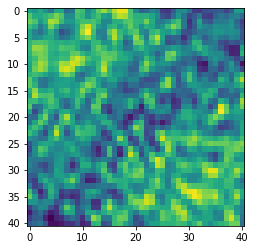

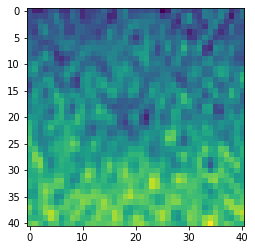

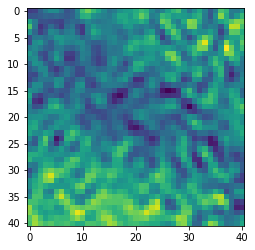

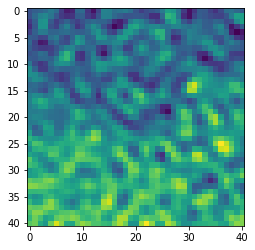

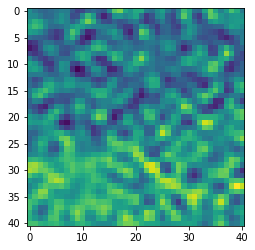

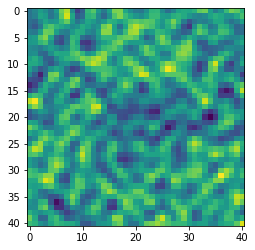

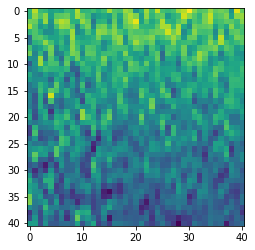

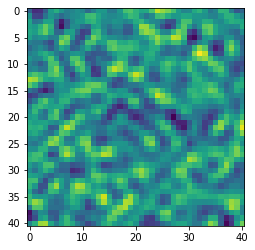

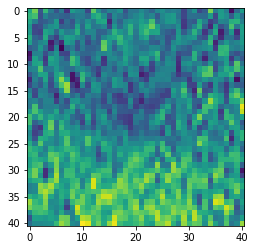

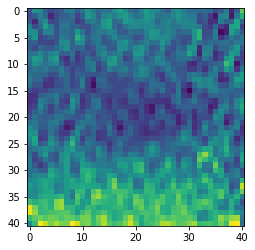

In [60]:
for i in range(10):
    plt.imshow(train_stamps[i,...,0])
    plt.show()
    plt.close()

# Compton y

In [38]:
data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'all_clusters.npz') as data:
    stamps = data['arr_0']

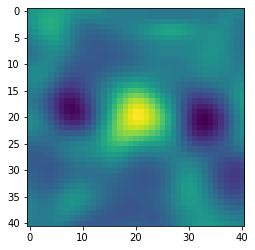

In [41]:
plt.imshow(stamps[10])

In [42]:
#cuts out any maps that have nans in them
flags = []
for i in range(stamps.shape[0]):
        if np.any(np.isnan(stamps[i,...])):
                flags.append(i)

stamps = np.delete(stamps, flags, axis = 0)

In [43]:
tot = stamps.shape[0]
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_stamps = stamps[:train_size]
val_stamps = stamps[train_size:train_size + val_size]
test_stamps = stamps[train_size + val_size:]

input_shape = train_stamps.shape[1:]

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

labels = act_catalog[1].data['M500Cal'][:tot]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_stamps, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_stamps, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_stamps, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [44]:
model = tf.keras.Sequential([
      tf.keras.layers.Flatten(input_shape=input_shape),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [45]:
toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(train_dataset, epochs=int(50), 
                    validation_data=val_dataset)
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss = model.evaluate(test_dataset, verbose=2)


Epoch 1/50
6/6 [==============================] - 1s 40ms/step - loss: 3.6790 - val_loss: 3.5986
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 3.6363 - val_loss: 3.5500
Epoch 3/50
6/6 [==============================] - 0s 19ms/step - loss: 3.5829 - val_loss: 3.4892
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 3.5160 - val_loss: 3.4127
Epoch 5/50
6/6 [==============================] - 0s 20ms/step - loss: 3.4319 - val_loss: 3.3166
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 3.3263 - val_loss: 3.1964
Epoch 7/50
6/6 [==============================] - 0s 20ms/step - loss: 3.1949 - val_loss: 3.0475
Epoch 8/50
6/6 [==============================] - 0s 20ms/step - loss: 3.0326 - val_loss: 2.8646
Epoch 9/50
6/6 [==============================] - 0s 21ms/step - loss: 2.8341 - val_loss: 2.6421
Epoch 10/50
6/6 [==============================] - 0s 20ms/step - loss: 2.5936 - val_loss: 2.3742
Epoch 11/50
6/6 [============

In [46]:
predictions = model.predict(train_dataset)
for i in range(len(train_labels)):
    print(train_labels[i]-predictions[i])

[-0.9062865]
[0.1634016]
[0.49456525]
[-1.2433548]
[-0.96045923]
[-0.4224565]
[-0.50634027]
[-0.5094502]
[0.8182738]
[0.2636385]
[-0.67818594]
[-0.63909984]
[-0.4359932]
[-0.00983691]
[0.9854667]
[-0.18943882]
[-1.0422442]
[0.008389]
[-0.292377]
[-0.8851237]
[-0.67614174]
[-0.19721341]
[5.716531]
[-0.915576]
[-0.9739671]
[2.646883]
[-0.6816571]
[-0.6347132]
[2.804798]
[0.67319965]
[-1.187896]
[0.8593137]
[-0.02485037]
[-0.98145366]
[0.78324604]
[-0.91588616]
[2.4311225]
[-0.7617605]
[-0.808265]
[0.5016463]
[1.3566711]
[-0.6499076]
[0.560992]
[0.07656741]
[-0.56783056]
[-1.3325005]
[0.38722777]
[-0.6268728]
[3.1003945]
[-0.00210905]
[0.39267945]
[0.72489166]
[0.14551997]
[-0.56652784]
[-1.104913]
[-0.7295661]
[-0.43111134]
[-1.1618099]
[0.79875374]
[-0.6183562]
[-1.018637]
[0.26165104]
[-1.1641581]
[0.40778255]
[-1.1356862]
[-0.44719028]
[5.147271]
[-0.06627703]
[-0.9243586]
[0.50821686]
[-0.7083628]
[-1.2004571]
[-0.51970434]
[1.2863028]
[0.14115739]
[-1.0498827]
[-0.497854]
[-0.692388

[-0.832824]
[0.6134131]
[-1.1097875]
[-0.2176454]
[0.56850266]
[0.30287004]
[-1.0058572]
[-0.22062874]
[-0.44657922]
[-0.39115644]
[1.0197048]
[-0.39237666]
[0.34828806]
[0.01388311]
[-0.7782626]
[-0.46422338]
[2.042291]
[0.1901195]
[-0.75825596]
[-0.8888023]
[0.24664736]
[0.259295]
[0.50630736]
[2.5970314]
[-0.94473743]
[-1.5861816]
[-0.10853052]
[-0.8280699]
[-0.7928729]
[-0.131078]
[4.4223757]
[4.9999704]
[1.5483131]
[0.9882033]
[0.9587319]
[0.13442254]
[-0.7045026]
[5.4081793]
[-0.7817223]
[-1.0709214]
[0.1348834]
[2.968706]
[-0.45754552]
[-0.7820251]
[1.011095]
[1.5661943]
[3.898634]
[-0.8236244]
[-0.1022594]
[-0.6837301]
[-0.43846607]
[0.32460356]
[-0.956048]
[-0.39319468]
[-1.3708162]
[0.5590956]
[-0.49163008]
[0.7755983]
[0.78264904]
[0.917289]
[-0.12785888]
[-0.37742877]
[-0.67767286]
[-0.84238195]
[-0.78180075]
[-0.58664536]
[0.00339127]
[-0.44361305]
[0.47201896]
[-0.20117736]
[-0.41037083]
[0.90955067]
[-1.2323277]
[-0.6940479]
[-0.7053361]
[-0.5282955]
[5.722656]
[-0.51838

[-0.01013803]
[0.3830073]
[0.41558886]
[1.2021112]
[-0.28339148]
[1.0697007]
[0.44869184]
[-0.07709479]
[-0.261034]
[0.27451253]
[-0.04584336]
[-0.6857462]
[1.4346585]
[-0.73544216]
[1.3487535]
[0.49365926]
[2.277415]
[0.3692441]
[2.3343084]
[4.201351]
[-0.09896755]
[0.05889416]
[-0.10425162]
[0.62154984]
[1.2386477]
[-0.11987233]
[-0.39603877]
[1.2165265]
[2.926766]
[-0.15386605]
[-0.33748317]
[-0.1230638]
[1.500864]
[-0.25779486]
[-0.6499789]
[-0.28507113]
[-0.7663815]
[-0.23041725]
[0.11274815]
[0.16328621]
[-1.1967947]
[-0.17925]
[-0.7261243]
[-0.8317163]
[-0.44809914]
[-0.47048807]
[0.04104781]
[0.82251024]
[2.0700688]
[-0.69855237]
[0.35563397]
[0.60385776]
[0.38768077]
[0.1411941]
[0.6867118]
[1.0419145]
[0.6022341]
[-0.46018362]
[0.61186266]
[1.3827307]
[-0.3166778]
[-0.7826257]
[-0.5629616]
[0.15950584]
[1.1618333]
[0.00524259]
[-0.01894379]
[1.0683327]
[2.971257]
[0.0541234]
[2.4776413]
[1.3381302]
[1.632004]
[-0.9925971]
[-0.5493145]
[-0.26398778]
[-0.4362707]
[-0.6585405]
[

[0.06737733]
[-0.36611295]
[-0.7770734]
[-0.837898]
[0.27921295]
[-0.93352103]
[0.8080838]
[0.32301998]
[1.9003713]
[-0.1170063]
[-0.48233223]
[-0.55057]
[1.3065543]
[4.598187]
[-0.27547812]
[3.435989]
[-0.7039418]
[-0.2510898]
[1.167767]
[-0.41932416]
[-1.1878276]
[0.56625533]
[-0.65313315]
[-0.63048315]
[2.9890373]
[-0.75490737]
[-0.7690232]
[-0.21416235]
[-1.0184197]
[-0.37381244]
[-0.7724242]
[-0.1493895]
[-0.81004596]
[0.93993354]
[-0.8776195]
[0.7697623]
[0.75491476]
[-0.37658978]
[-0.37203765]
[0.9307661]
[-0.3880992]
[0.87637234]
[-1.311862]
[-0.42980385]
[-0.09234929]
[-0.19331098]
[0.16679645]
[-1.0901213]
[-0.86443543]
[0.00611401]
[-1.0296192]
[-0.74977374]
[-0.7005327]
[-0.01119828]
[1.6092706]
[0.05066848]
[1.691128]
[-0.3162539]
[-0.23104763]
[-0.8127284]
[1.4226022]
[0.24890256]
[-0.06432748]
[0.7312722]
[1.058254]
[-1.1456594]
[-0.30064392]
[2.7647595]
[-0.59156156]
[0.8264098]
[1.144248]
[-0.5084226]
[2.2177293]
[-0.4748578]
[-0.3211081]
[-0.78643036]
[0.25959897]
[1.